Import necessary libraries

In [115]:
import pandas as pd
import requests
import json
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import gc



# Downloading data (Traffic and Air quality). 
Automatically downloads from the following dates :

In [116]:

download_from = datetime(2024, 1, 1)
download_until = datetime(2024, 10, 28) # Note that the days of the month do not matter (as long as they exist). This selects data with a precision of a month.

Then run the following to actually download the files.

In [117]:

# Catalan month names
catalan_months = {
    1: "Gener",
    2: "Febrer",
    3: "Marc",
    4: "Abril",
    5: "Maig",
    6: "Juny",
    7: "Juliol",
    8: "Agost",
    9: "Setembre",
    10: "Octubre",
    11: "Novembre",
    12: "Desembre",
}

# Trams transit relacio (relation between ids and locations)
trams_relacio_url = "https://opendata-ajuntament.barcelona.cat/data/dataset/1090983a-1c40-4609-8620-14ad49aae3ab/resource/1d6c814c-70ef-4147-aa16-a49ddb952f72/download/transit_relacio_trams.csv"
trams_relacio_path = "./data/transit_relacio_trams.csv"

# Air quality stations info (including lat and long)
# (The stations are unchanged since 2023 so downloading only the 2025 version is enough)
air_stations_info_url = "https://opendata-ajuntament.barcelona.cat/data/dataset/4dff88b1-151b-48db-91c2-45007cd5d07a/resource/d1aa40d7-66f9-451b-85f8-955b765fdc2f/download/2025_qualitat_aire_estacions.csv"
air_stations_info_path = "./data/air_stations_info.csv"

def generate_urls(download_from, download_until):
    urls = []
    current_date = datetime(download_from.year, download_from.month, 1)
    end_date = datetime(download_until.year, download_until.month, 1)

    while current_date <= end_date:
        year = current_date.year
        month = current_date.month
        month_name = catalan_months[month]

        # Generate URLs for both datasets
        tram_url = f"https://opendata-ajuntament.barcelona.cat/resources/auto/transit/{year}_{month:02d}_{month_name}_TRAMS_TRAMS.csv"
        aire_url = f"https://opendata-ajuntament.barcelona.cat/resources/bcn/QualitatAire/{year}_{month:02d}_{month_name}_qualitat_aire_BCN.csv"

        tram_filename = f"data/TRAMS_{year}_{month:02d}_{month_name}.csv"
        aire_filename = f"data/QualitatAire_{year}_{month:02d}_{month_name}.csv"

        urls.append((tram_url, tram_filename))
        urls.append((aire_url, aire_filename))

        # Move to the next month
        if current_date.month == 12:
            current_date = datetime(current_date.year + 1, 1, 1)
        else:
            current_date = datetime(current_date.year, current_date.month + 1, 1)

    return urls

def download_file(url, filename):
    if os.path.exists(filename):
        print(f"File already exists: {filename}. Skipping download.")
        return

    try:
        response = requests.get(url, stream=True)
        response.raise_for_status()
        with open(filename, 'wb') as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)
        print(f"Downloaded: {filename}")
    except Exception as e:
        print(f"Failed to download {filename}: {e}")


# Create a "data" folder:
if not os.path.exists("./data"):
    os.mkdir("./data")

urls = generate_urls(download_from, download_until)

print("Dwonloading files...")
for url, filename in urls:
    download_file(url, filename)


# Then download the TRAMS relacio file
if not os.path.exists(trams_relacio_path):
    download_file(trams_relacio_url, trams_relacio_path)


# And the air stations info 
if not os.path.exists(air_stations_info_path):
    download_file(air_stations_info_url, air_stations_info_path)

Dwonloading files...
File already exists: data/TRAMS_2024_01_Gener.csv. Skipping download.
File already exists: data/QualitatAire_2024_01_Gener.csv. Skipping download.
File already exists: data/TRAMS_2024_02_Febrer.csv. Skipping download.
File already exists: data/QualitatAire_2024_02_Febrer.csv. Skipping download.
File already exists: data/TRAMS_2024_03_Marc.csv. Skipping download.
File already exists: data/QualitatAire_2024_03_Marc.csv. Skipping download.
File already exists: data/TRAMS_2024_04_Abril.csv. Skipping download.
File already exists: data/QualitatAire_2024_04_Abril.csv. Skipping download.
File already exists: data/TRAMS_2024_05_Maig.csv. Skipping download.
File already exists: data/QualitatAire_2024_05_Maig.csv. Skipping download.
File already exists: data/TRAMS_2024_06_Juny.csv. Skipping download.
File already exists: data/QualitatAire_2024_06_Juny.csv. Skipping download.
File already exists: data/TRAMS_2024_07_Juliol.csv. Skipping download.
File already exists: data/Qual

# Data treatment and cleaning


## Creating a merged dataset

### Combining all the air quality files

In [118]:
## Create dataframe of measurements

air_quality_files = [filename for url, filename in urls if "QualitatAire" in filename]
#print(air_quality_files)

# Covnert to pandas dataframes
air_quality_dfs = [pd.read_csv(file) for file in air_quality_files]
# Combine them into a single dataframe
air_quality = pd.concat(air_quality_dfs, ignore_index=True)
#print(air_quality_combined.head())



# Only keep PM10 DATA
air_quality = air_quality[air_quality["CODI_CONTAMINANT"].isin([10, 110])]
print(air_quality.head())




## Create dataframe of station info
air_station_info = pd.read_csv(air_stations_info_path)
# Only keep location data for each station
air_station_locations = air_station_info[['Estacio', 'Latitud', 'Longitud']].drop_duplicates(subset=['Estacio'])
#print(air_station_locations.head(n=20))

""" ## Now merge the air_quality measurements and the location

air_quality = air_quality_combined.merge(
    right=air_station_locations,
    left_on='ESTACIO',
    right_on='Estacio',
    how='left'
).drop(columns=['Estacio'])

print(air_quality.head()) """

    CODI_PROVINCIA  PROVINCIA  CODI_MUNICIPI   MUNICIPI  ESTACIO  \
62               8  Barcelona             19  Barcelona        4   
63               8  Barcelona             19  Barcelona        4   
64               8  Barcelona             19  Barcelona        4   
65               8  Barcelona             19  Barcelona        4   
66               8  Barcelona             19  Barcelona        4   

    CODI_CONTAMINANT   ANY  MES  DIA   H01  ...   H20  V20   H21  V21   H22  \
62                10  2024    1    1  34.0  ...  13.0    V  14.0    V  25.0   
63                10  2024    1    2  19.0  ...  36.0    V  37.0    V  29.0   
64                10  2024    1    3  30.0  ...  29.0    V  19.0    V  15.0   
65                10  2024    1    4  25.0  ...  30.0    V  28.0    V  27.0   
66                10  2024    1    5  26.0  ...  13.0    V   7.0    V   5.0   

    V22   H23  V23   H24  V24  
62    V  21.0    V  19.0    V  
63    V  29.0    V  24.0    V  
64    V  19.0    V  

" ## Now merge the air_quality measurements and the location\n\nair_quality = air_quality_combined.merge(\n    right=air_station_locations,\n    left_on='ESTACIO',\n    right_on='Estacio',\n    how='left'\n).drop(columns=['Estacio'])\n\nprint(air_quality.head()) "

### Combining traffic files

In [119]:
## Create dataframe of measurements

traffic_files = [filename for url, filename in urls if "TRAMS" in filename]

# Covnert to pandas dataframes
traffic_dfs = [pd.read_csv(file) for file in traffic_files]
#print(traffic_dfs[0].head())

# Combine them into a single dataframe
traffic_combined = pd.concat(traffic_dfs, ignore_index=True)
print(traffic_combined.head())


# Drop the rows with no data (estatActual=0)
traffic_combined = traffic_combined.query("estatActual != 0")


## Create dataframe of station info
trams_info = pd.read_csv(trams_relacio_path)
# Only keep location data for each station
trams_locations = trams_info[['Tram', 'Coordenades']]

# Only keep one location point per section (tram=section)
def mean_coordinate(row):
    # print("entering function mean")
    # print(row)
    coord_text=row['Coordenades']
    numbers=coord_text.split(',')
    assert len(numbers) % 2 == 0
    lons = [float(x) for x in numbers[::2]]
    lats = [float(x) for x in numbers[1::2]]
    # print("infos")
    # print(lats)
    # print(type(lats[0]))
    lat = np.mean(lats)
    lon = np.mean(lons)
    return pd.Series(
        {
            'lat': lat,
            'lon': lon
        }
    )


trams_locations [['lat' , 'lon']] = trams_locations.apply(mean_coordinate, axis=1)
#print(trams_locations.head())


## Now merge the traffic measurements and the location
traffic = traffic_combined.merge(
    right=trams_locations,
    left_on='idTram',
    right_on='Tram',
    how='left'
)

traffic = traffic.drop(['Coordenades', 'Tram', 'estatPrevist'], axis=1)

print("RESULT FINA")
print(traffic.head())

   idTram            data  estatActual  estatPrevist
0       1  20240101000552            0             0
1       2  20240101000552            0             0
2       3  20240101000552            0             0
3       4  20240101000552            0             0
4       5  20240101000552            0             0
RESULT FINA
   idTram            data  estatActual        lat       lon
0      27  20240101000552            2  41.382080  2.114583
1      62  20240101000552            1  41.396526  2.146327
2      67  20240101000552            1  41.408015  2.138228
3      69  20240101000552            1  41.402681  2.144603
4      97  20240101000552            2  41.401097  2.136411


## Dataset issue

For some reason, the city does not provide information for the 'trams' with id greater than 527. In the `traffic` dataframe, there are some records with idTram between 535 and 539. They don't have a latitude/longitude. Let us drop them.

In [120]:
traffic = traffic.dropna(subset=['lat', 'lon'])

# Defining a traffic grid

Now, `traffic` contains the state (from 0-no car to 6-congestioned) of plenty of coordinates in Barcelona. But the density is not homogeneous, hence i will cut the city in a grid and compute an average value for traffic congestion.

In [121]:
# Getting the boundaries of the traffic information
minlat = traffic['lat'].min()
maxlat = traffic['lat'].max()
minlon = traffic['lon'].min()
maxlon = traffic['lon'].max()

# Print box size
mean_lat = (minlat + maxlat) / 2
lat_km = (maxlat - minlat) * 111
lon_km = (maxlon - minlon) * 111 * np.cos(np.radians(mean_lat))
print(f"Bounding box size: {lat_km:.2f} km (vertical) x {lon_km:.2f} km (horizontal)")


nb_horizontal = 3
nb_vertical = 3

vertical_step = (maxlat - minlat) / nb_vertical
horizontal_step = (maxlon - minlon) / nb_horizontal


# Create new datafram from traffic

""" def getZone(row):
    lat = (row['lat'] - minlat) // vertical_step
    lon = (row['lon'] - minlon) // horizontal_step
    zone_number = (lat * nb_horizontal) + lon


traffic['zone'] = traffic.apply(getZone, axis=1) """
# BETTER WAY (vectorized)
# Create nb_vertical * nb_horizontal zones and assign every row a zone:
lat_idx = np.clip(np.floor((traffic['lat'] - minlat) / vertical_step).astype(int), 0, nb_vertical - 1)
lon_idx = np.clip(np.floor((traffic['lon'] - minlon) / horizontal_step).astype(int), 0, nb_horizontal - 1)
traffic['zone'] = lat_idx * nb_horizontal + lon_idx



# Sanity: list of all possible zones
all_zones = list(range(nb_vertical * nb_horizontal))

# How many unique sensors per zone (global)
sensor_counts = traffic.groupby('zone')['idTram'].nunique().reindex(all_zones, fill_value=0)
print("Unique-sensor counts per zone:\n", sensor_counts)

# Which zones have >=5 sensors (global)
valid_zones = sensor_counts[sensor_counts >= 5].index.tolist()
discarded_zones = [z for z in all_zones if z not in valid_zones]
print(f"Discarding {len(discarded_zones)} zones with < 5 sensors: {discarded_zones}")

# Keep only valid zones
traffic = traffic[traffic['zone'].isin(valid_zones)].copy()

# Drop lat/lon as we will now use the zone
traffic = traffic.drop(['lat', 'lon'], axis=1)


Bounding box size: 11.48 km (vertical) x 9.87 km (horizontal)
Unique-sensor counts per zone:
 zone
0     13
1     33
2      0
3     86
4    149
5     62
6      6
7     46
8     43
Name: idTram, dtype: int64
Discarding 1 zones with < 5 sensors: [2]


We can see the shape of the grid and which cells were kept using the following code (made quickly with ChatGPT)

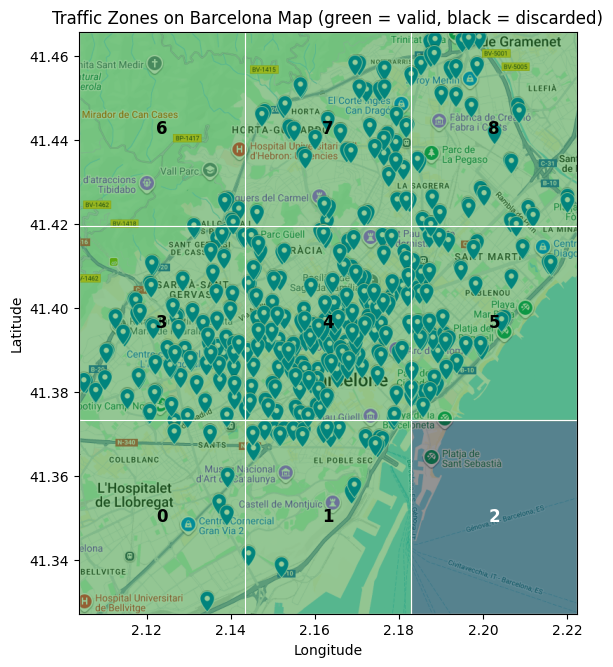

In [122]:
# --- Load background image ---
img = mpimg.imread("Barcelona_bg.png")
img_h, img_w = img.shape[:2]
img_aspect = img_h / img_w  # e.g. 712/832 ≈ 0.855

# --- Compute grid extent with the same aspect ratio as the image ---
lon_range = maxlon - minlon
lat_range = maxlat - minlat
side_lon = lon_range
side_lat = lon_range * img_aspect  # adjust vertical range to match image ratio

# Center vertically around the midpoint
mid_lat = (minlat + maxlat) / 2
minlat_adj = mid_lat - side_lat / 2
maxlat_adj = mid_lat + side_lat / 2

# --- Draw ---
fig, ax = plt.subplots(figsize=(6, 6 * img_aspect))

# Show image fitted to adjusted extent
ax.imshow(
    img,
    extent=[minlon, maxlon, minlat_adj, maxlat_adj],
    origin='upper'
)

# --- Draw semi-transparent grid cells ---
for lat_idx in range(nb_vertical):
    for lon_idx in range(nb_horizontal):
        zone = lat_idx * nb_horizontal + lon_idx
        
        cell_min_lat = minlat_adj + lat_idx * (side_lat / nb_vertical)
        cell_max_lat = cell_min_lat + (side_lat / nb_vertical)
        cell_min_lon = minlon + lon_idx * (side_lon / nb_horizontal)
        cell_max_lon = cell_min_lon + (side_lon / nb_horizontal)
        
        color = 'green' if zone in valid_zones else 'black'
        
        ax.fill_between(
            [cell_min_lon, cell_max_lon],
            cell_min_lat, cell_max_lat,
            color=color, alpha=0.4
        )
        
        # Zone label
        center_lat = (cell_min_lat + cell_max_lat) / 2
        center_lon = (cell_min_lon + cell_max_lon) / 2
        ax.text(center_lon, center_lat, str(zone),
                ha='center', va='center',
                fontsize=12,
                color='white' if color == 'black' else 'black',
                weight='bold')

# --- Grid lines ---
for i in range(nb_horizontal + 1):
    x = minlon + i * (side_lon / nb_horizontal)
    ax.plot([x, x], [minlat_adj, maxlat_adj], color='white', linewidth=1)

for j in range(nb_vertical + 1):
    y = minlat_adj + j * (side_lat / nb_vertical)
    ax.plot([minlon, maxlon], [y, y], color='white', linewidth=1)

# --- Style ---
ax.set_xlim(minlon, maxlon)
ax.set_ylim(minlat_adj, maxlat_adj)
ax.set_aspect('equal', adjustable='box')
ax.set_title("Traffic Zones on Barcelona Map (green = valid, black = discarded)")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.tight_layout()
plt.show()

# Merging all the data
We are then going to merge both of the dataframes


## Modification of the `traffic` dataframe
Traffic measurements are made more or less 10 minutes around o'clock hours. Then we will round the time to the nearest hour. Then we will melt the dataframe so that [hour, date] is a primary key.

In [123]:
# Covnert the 'data' (date) column of traffic dataframe
traffic["datetime"] = pd.to_datetime(traffic["data"], format="%Y%m%d%H%M%S")

# Traffic measurements are made more or less 10 minutes around o'clock hours. Then we will round the time to the nearest hour 
traffic["datetime_hour"] = traffic["datetime"].dt.round("h")
traffic["date"] = traffic["datetime_hour"].dt.date
traffic["hour"] = traffic["datetime_hour"].dt.hour


# Use 85th percentile instead of the median (50th percentile)
def percentile_85(x):
    return np.percentile(x, 85)

# Pivoting
traffic = traffic.pivot_table(
    index=['date', 'hour'],
    columns=['zone'],
    values='estatActual',
    aggfunc=percentile_85
).add_prefix('traffic_z').reset_index()

print(f"Remaining zones after filtering: {traffic.columns[2:].tolist()}")
print(traffic.head())



Remaining zones after filtering: ['traffic_z0', 'traffic_z1', 'traffic_z3', 'traffic_z4', 'traffic_z5', 'traffic_z6', 'traffic_z7', 'traffic_z8']
zone        date  hour  traffic_z0  traffic_z1  traffic_z3  traffic_z4  \
0     2024-01-01     0         2.0         2.0         1.0         2.0   
1     2024-01-01     1         3.0         2.0         2.0         2.0   
2     2024-01-01     2         2.0         2.0         2.0         2.0   
3     2024-01-01     3         2.0         2.0         2.0         2.0   
4     2024-01-01     4         3.0         1.0         1.0         2.0   

zone  traffic_z5  traffic_z6  traffic_z7  traffic_z8  
0            2.0         1.0         1.0         1.0  
1            2.0         2.0         2.0         2.0  
2            2.0         2.0         2.0         2.0  
3            2.0         2.0         2.0         2.0  
4            2.0         1.0         1.0         1.0  


## Modification of the `air_quality` dataframe
The hours are currently in the columns, we are going to melt the dataframe to have a long one with dates in the rows.

We also want [hour,date] to be a primary key so that merging both dataframes does not explodes RAM usage.

In [124]:
# Get the hours columns name
hour_cols = [col for col in air_quality.columns if col.startswith("H") and len(col) == 3]

# Then use pandas melt method to reshape the DF

aq_melted = air_quality.melt(
    # Columns left untouched
    id_vars=["CODI_PROVINCIA", "PROVINCIA", "CODI_MUNICIPI", "MUNICIPI", "ESTACIO", "ANY", "MES", "DIA"], # IMPORTANT: i removed CODI_CONTAMINANT because i only kept PM10 temporarily

    #Columns to unpivot
    value_vars=hour_cols,

    #Name of the new column that will store the unpivoted columns names (H01 etc.)
    var_name="hour_str",

    #Name of the actual value column
    value_name="pollution_value"
)
    
# Clean the hour (H01->1)
aq_melted["hour"] = aq_melted["hour_str"].str.extract(r"H(\d{2})").astype("int32")



# Create the actual date column (and translate column names)
aq_melted["date"] = pd.to_datetime(
    aq_melted[["ANY", "MES", "DIA"]].rename(columns={"ANY": "year", "MES": "month", "DIA": "day"})
).dt.date

#Shift the H24 columns to hour 0 of the next day:
mask_24 = aq_melted["hour"] == 24
aq_melted.loc[mask_24, "hour"] = 0
aq_melted.loc[mask_24, "date"] = pd.to_datetime(aq_melted.loc[mask_24, "date"]) + pd.Timedelta(days=1)
aq_melted["date"] = pd.to_datetime(aq_melted["date"]).dt.date


# Pivot (CODI_CONTAMINANT,ESTACIO) so that [hour, date] is primary key
aq_pivoted = aq_melted.pivot_table(
    index=['date', 'hour'],
    columns=['ESTACIO'], # IMPORTANT: here i also remove CODI_CONTAMINANT since there is only one.
    values='pollution_value',
    aggfunc='first'
).reset_index()

# Simple flattening (for more meaningful column names)
""" aq_pivoted.columns = ['date', 'hour'] + [
    f'pollutant_{col[0]}_station_{col[1]}' 
    for col in aq_pivoted.columns[2:]
] """
aq_pivoted.columns = ['date', 'hour'] + [
    f'station_{col}' 
    for col in aq_pivoted.columns[2:]
]

print(aq_pivoted.head(200))


           date  hour  station_4  station_43  station_44  station_54  \
0    2024-01-01     1       34.0        43.0        33.0        23.0   
1    2024-01-01     2       34.0        36.0        29.0        26.0   
2    2024-01-01     3       34.0        30.0        32.0        18.0   
3    2024-01-01     4       27.0        34.0        26.0        14.0   
4    2024-01-01     5       24.0        35.0        28.0        18.0   
..          ...   ...        ...         ...         ...         ...   
195  2024-01-09     4       17.0        11.0         6.0         8.0   
196  2024-01-09     5       13.0        10.0         7.0         6.0   
197  2024-01-09     6       11.0        10.0         7.0         5.0   
198  2024-01-09     7       13.0        12.0        12.0        10.0   
199  2024-01-09     8       33.0        21.0        24.0        14.0   

     station_57  station_58  
0          16.0        14.0  
1          25.0        18.0  
2          21.0        14.0  
3          16.0

## Dataframes cleaning
Before merging the datasets, we have to ensure the hourly time is continous. We also should monitor and fill the NaN values.
It is important to do so before merging, to minimise the effect on the final dataset.

In [125]:
def fill_missing_values(df):
    bad_value_proportion = (df.isnull().sum().sum() / df.size) * 100
    print(f"Proportion of bad (Nan) values: {bad_value_proportion:.2f}%")
    df = df.ffill().bfill()
    bad_value_proportion = (df.isnull().sum().sum() / df.size) * 100
    print(f"Proportion of bad (Nan) values after filling: {bad_value_proportion:.2f}%")



    # Detect missing rows (hours when one of the measurement systems was down)
    print("Gaps in time axis")
    # Combine date and hour into a single datetime
    df['datetime_hour'] = pd.to_datetime(df['date'].astype(str)) + pd.to_timedelta(df['hour'], unit='h')

    # Sort by time
    df = df.sort_values('datetime_hour').reset_index(drop=True)

    # Create a full range from the min to max timestamp
    full_range = pd.date_range(start=df['datetime_hour'].min(),
                            end=df['datetime_hour'].max(),
                            freq='h')
    missing_times = full_range.difference(df['datetime_hour'])
    if len(missing_times) > 0:
        print(f"{len(missing_times)} Missing hourly entries detected, trying to fill them...")
        """ for t in missing_times:
            print(" -", t) """
    else:
        print("No missing hours — data is continuous.")


    # Filling the missing rows with Nan
    # Use datetime_hour as index
    df = df.set_index('datetime_hour')

    # Reindex to include all hours
    df = df.reindex(full_range)

    # Restore date/hour columns if needed
    df['date'] = df.index.date
    df['hour'] = df.index.hour
    df = df.reset_index(drop=True)

    # Then we have to fill the NaN
    for col in df.columns:
        # First ytr to fill with value from previous week
        prev_week = df[col].shift(24 * 7)  # shift by 7 days
        df[col] = df[col].fillna(prev_week)

        # SThen fill with value from next week
        next_week = df[col].shift(-24 * 7)
        df[col] = df[col].fillna(next_week)

    df = df.ffill()

    # Re-run the check
    # Combine date and hour into a single datetime
    df['datetime_hour'] = pd.to_datetime(df['date'].astype(str)) + pd.to_timedelta(df['hour'], unit='h')

    # Sort by time
    df = df.sort_values('datetime_hour').reset_index(drop=True)
    full_range = pd.date_range(start=df['datetime_hour'].min(),
                            end=df['datetime_hour'].max(),
                            freq='h')
    missing_times = full_range.difference(df['datetime_hour'])
    if len(missing_times) > 0:
        print(f"{len(missing_times)} Missing hourly entries detected:")
        """ for t in missing_times:
            print(" -", t) """
    else:
        print("No missing hours — data is continuous.")
    return df



In [126]:
# Perform the cleaning on the two dataframes
print("Cleaning and filling 'traffic'...")
traffic = fill_missing_values(traffic)

print("Cleaning and filling 'aq_pivoted'...")
aq_pivoted = fill_missing_values(aq_pivoted)

Cleaning and filling 'traffic'...
Proportion of bad (Nan) values: 0.02%
Proportion of bad (Nan) values after filling: 0.00%
Gaps in time axis
418 Missing hourly entries detected, trying to fill them...
No missing hours — data is continuous.
Cleaning and filling 'aq_pivoted'...
Proportion of bad (Nan) values: 14.75%
Proportion of bad (Nan) values after filling: 0.00%
Gaps in time axis
1 Missing hourly entries detected, trying to fill them...
No missing hours — data is continuous.


In [127]:
# Now do the actual merging based on time

merged = pd.merge(
    traffic,
    aq_pivoted,
    how="left",
    left_on=["date", "hour"],
    right_on=["date", "hour"]
)

# is_primary_key = not traffic.duplicated(subset=['date', 'hour']).any()
# print(f"Is [date, hour] a primary key? {is_primary_key}")
print("Cleaning and filling 'merged'...")
merged = fill_missing_values(merged)
print(merged.head())
print("Final DF")
print(merged.head(30))

Cleaning and filling 'merged'...
Proportion of bad (Nan) values: 0.01%
Proportion of bad (Nan) values after filling: 0.00%
Gaps in time axis
No missing hours — data is continuous.
No missing hours — data is continuous.
         date  hour  traffic_z0  traffic_z1  traffic_z3  traffic_z4  \
0  2024-01-01     0         2.0         2.0         1.0         2.0   
1  2024-01-01     1         3.0         2.0         2.0         2.0   
2  2024-01-01     2         2.0         2.0         2.0         2.0   
3  2024-01-01     3         2.0         2.0         2.0         2.0   
4  2024-01-01     4         3.0         1.0         1.0         2.0   

   traffic_z5  traffic_z6  traffic_z7  traffic_z8     datetime_hour_x  \
0         2.0         1.0         1.0         1.0 2024-01-01 00:00:00   
1         2.0         2.0         2.0         2.0 2024-01-01 01:00:00   
2         2.0         2.0         2.0         2.0 2024-01-01 02:00:00   
3         2.0         2.0         2.0         2.0 2024-01-01 0

Now, we have a complete dataset (whithout the weather for now)

But some values are missing (evrytime I checked, around 0.1-0.5% of the cells are NaN).
Let us just fill them forward/backwards

# Adding the weather data

In [128]:
# Barcelona location
lat = 41.38
lon = 2.18
timezone = "Europe/Madrid"

# Defining the time range for the request
start = merged['datetime_hour'].min().strftime('%Y-%m-%dT%H:%M')
end = merged['datetime_hour'].max().strftime('%Y-%m-%dT%H:%M')

# File to cache results
cache_file = f"data/weather_{start[:10]}_{end[:10]}.json"

# Fetch or load from cache
if os.path.exists(cache_file):
    print(f"Using cached weather data from {cache_file}")
    with open(cache_file, "r") as f:
        weather_data = json.load(f)
else:
    print("Fetching weather data from Open-Meteo API...")
    url = (
        f"https://archive-api.open-meteo.com/v1/archive"
        f"?latitude={lat}&longitude={lon}"
        f"&start_date={start[:10]}&end_date={end[:10]}"
        f"&hourly=temperature_2m,windspeed_10m,winddirection_10m,precipitation,relative_humidity_2m,surface_pressure,cloudcover"
        f"&timezone={timezone}"
    )

    resp = requests.get(url)
    resp.raise_for_status()
    weather_data = resp.json()

    # Save to cache file
    with open(cache_file, "w") as f:
        json.dump(weather_data, f)
    print(f"Saved weather data to {cache_file}")

# Create the DF
hourly = weather_data["hourly"]
weather = pd.DataFrame({
    "datetime_hour": hourly["time"],
    "temperature": hourly["temperature_2m"],
    "wind_speed": hourly["windspeed_10m"],
    "wind_direction": hourly["winddirection_10m"],
    "precipitation": hourly["precipitation"],  # mm of rain
    "humidity": hourly["relative_humidity_2m"],  # %
    "pressure": hourly["surface_pressure"],  # hPa
    "cloud_cover": hourly["cloudcover"],  # %
})
weather["datetime_hour"] = pd.to_datetime(weather["datetime_hour"])

# Add binary rain indicator
weather["is_raining"] = (weather["precipitation"] > 0).astype(int)

# Encode wind direction (degrees are circular, hence not very meaningful. We will encode both speed and direction as a horizontal vector)
weather["wind_u"] = weather["wind_speed"] * np.sin(np.deg2rad(weather["wind_direction"]))
weather["wind_v"] = weather["wind_speed"] * np.cos(np.deg2rad(weather["wind_direction"]))

weather = weather.drop(['wind_speed', 'wind_direction'], axis=1)

# Merge with the traffic/air quality
merged = merged.merge(weather, how="left", on="datetime_hour")

print("Weather data merged successfully!!")
print(merged.head())

Using cached weather data from data/weather_2024-01-01_2024-11-01.json
Weather data merged successfully!!
         date  hour  traffic_z0  traffic_z1  traffic_z3  traffic_z4  \
0  2024-01-01     0         2.0         2.0         1.0         2.0   
1  2024-01-01     1         3.0         2.0         2.0         2.0   
2  2024-01-01     2         2.0         2.0         2.0         2.0   
3  2024-01-01     3         2.0         2.0         2.0         2.0   
4  2024-01-01     4         3.0         1.0         1.0         2.0   

   traffic_z5  traffic_z6  traffic_z7  traffic_z8  ...     datetime_hour_y  \
0         2.0         1.0         1.0         1.0  ... 2024-01-01 01:00:00   
1         2.0         2.0         2.0         2.0  ... 2024-01-01 01:00:00   
2         2.0         2.0         2.0         2.0  ... 2024-01-01 02:00:00   
3         2.0         2.0         2.0         2.0  ... 2024-01-01 03:00:00   
4         2.0         1.0         1.0         1.0  ... 2024-01-01 04:00:00   

## The dataset is now complete and clean

Saving it to two files:
- one named `final_dataset.pkl` for regression and unsupervised learning
- one named `final_dataset_classification` for classification

In [ ]:
# Save the main one
merged.to_pickle('created_dataset.pkl')

# Convert the PM10 pollution values to good, medium, bad and then save the dataframe.

# Thresholds for PM10 (in µg/m3) based on common EU PM10 air quality guidelines
# - good: 0–20
# - medium: 20–40
# - bad: >40

def label_pm10(value):
    if pd.isna(value):
        return None
    elif value <= 20:
        return "good"
    elif value <= 40:
        return "medium"
    else:
        return "bad"

# Suppose your DataFrame is named df
# Automatically find all station columns
station_cols = [col for col in merged.columns if "station_" in col]

# Apply the labeling function to each station column
merged[station_cols] = merged[station_cols].map(label_pm10)

print(merged[station_cols].head())

merged.to_pickle('created_dataset_classes.pkl')

  station_4 station_43 station_44 station_54 station_57 station_58
0    medium        bad     medium     medium       good       good
1    medium        bad     medium     medium       good       good
2    medium     medium     medium     medium     medium       good
3    medium     medium     medium       good     medium       good
4    medium     medium     medium       good       good       good
